In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Helpers import load, textpreprocess
import pandas as pd

# Load Data:

In [6]:
filing_link = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1679688/000167968821000085/dbrg-20210630.htm"
entry_soup = load.load_soup_from_file_or_edgar(filing_link)
full_text = textpreprocess.get_text_from_soup(entry_soup)
sentences = textpreprocess.split_into_sentences(full_text)
cleaned_sentences = textpreprocess.lemmatize_sentences_and_remove_stop_words(sentences, remove_digits=True)

In [19]:
all_spans = entry_soup.find_all("span")
all_spans = [span for span in all_spans if len(span.text.split(" ")) > 10]
all_paragraphs = [span.text for span in all_spans if span.parent.name != "td"]

In [7]:
filing_df.head()

,Dirty,Clean
0,Table of Contents UNITED STATES SECURITIES AND...,table content united state security exchange c...
1,Employer Identification No.),employer identification no
2,"750 Park of Commerce Drive, Suite 210 Boca Rat...",park commerce drive suite boca raton florida a...
3,Yes No Indicate by check mark whether the regi...,yes indicate check mark whether registrant ha ...
4,Yes No Table of Contents Indicate by check mar...,yes table content indicate check mark whether ...


# Fit Model

In [20]:
vectorizer = TfidfVectorizer().fit(cleaned_sentences)
sentence_vectors = vectorizer.transform(cleaned_sentences).toarray()
paragraph_vectors = vectorizer.transform(all_paragraphs).toarray()

# Using Pandas to filter similar paragraphs using the cosine similarity

In [21]:
df = pd.DataFrame(cosine_similarity(paragraph_vectors))

In [22]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,575,576,577,578,579,580,581,582,583,584
0,1.000000,0.704532,0.269613,0.516992,0.481136,0.259802,0.170537,0.029149,0.061445,0.264487,...,0.249406,0.306829,0.311506,0.312543,0.319602,0.320592,0.128181,0.199364,0.471223,0.476171
1,0.704532,1.000000,0.234246,0.451342,0.456798,0.257217,0.136597,0.000000,0.000000,0.224486,...,0.175542,0.257350,0.363735,0.364946,0.326925,0.327938,0.078062,0.200898,0.474161,0.430468
2,0.269613,0.234246,1.000000,0.309552,0.371941,0.202617,0.163621,0.027967,0.058954,0.176834,...,0.096076,0.122829,0.181900,0.182506,0.156564,0.157049,0.061491,0.115017,0.156424,0.223296
3,0.516992,0.451342,0.309552,1.000000,0.474901,0.185863,0.099066,0.000000,0.000000,0.243833,...,0.180096,0.247994,0.326020,0.338388,0.342742,0.354690,0.094917,0.202439,0.275563,0.388089
4,0.481136,0.456798,0.371941,0.474901,1.000000,0.304354,0.129916,0.000000,0.000000,0.259947,...,0.125734,0.216604,0.315074,0.316123,0.258236,0.259036,0.000000,0.195405,0.192524,0.414294


In [23]:
df = df.reset_index()
df = df.melt("index")
df.columns = ["Text", "ComparedTo", "Similarity"]

In [24]:
df.head()

,Text,ComparedTo,Similarity
0,0,0,1.000000
1,1,0,0.704532
2,2,0,0.269613
3,3,0,0.516992
4,4,0,0.481136


In [25]:
similar_paragraphs = df.query(".6 < Similarity < .95 and Text != ComparedTo")

similar_text_tuple = set()

# this is a list comprehension to add paragraphs to a tuple. Because cosine similarity has duplicate values where TextOne and TextTwo will be swapped. So this makes sure our pairs are unique
temp_ = [similar_text_tuple.add((a, b, c)) for (a, b, c) in similar_paragraphs[["Text", "ComparedTo", "Similarity"]].values if (a, b, c) and (b, a, c) not in similar_text_tuple]

similar_text_df = pd.DataFrame(similar_text_tuple)
similar_text_df.columns = ["Text", "ComparedTo", "Similarity"]
similar_text_df["TextOne"] = similar_text_df["Text"].apply(lambda x: all_paragraphs[x])
similar_text_df["TextTwo"] = similar_text_df["ComparedTo"].apply(lambda x: all_paragraphs[x])

similar_text_df = similar_text_df[~similar_text_df["TextOne"].str.contains("The following table")]

# to ensure that similar sentences are not in the same section
similar_text_df = similar_text_df.query("Text - ComparedTo > 3").sort_values("Similarity")

<AxesSubplot:>

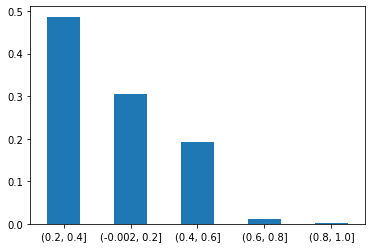

In [35]:
df.Similarity.value_counts(bins=5, normalize=True).plot(kind="bar", rot=0)

In [32]:
similar_text_df.query("Similarity > .8")

,Text,ComparedTo,Similarity,TextOne,TextTwo
1825,279,186,0.804537,Equity-based compensation related to BRSP awar...,Includes equity-based compensation of $4.5 mil...
1253,103,92,0.806600,from such resolution. The Company increased it...,Depreciation of real estate held for investmen...
2001,295,232,0.807160,The Company co-invests alongside its sponsored...,—The Company does not consolidate its sponsore...
152,301,284,0.810754,"three months ended June 30, 2021 and 2020, res...","Such cost reimbursements, included in other in..."
321,178,113,0.811462,"—In the first quarter of 2021, investor relati...","During the year ended December 31, 2020, an in..."
1782,393,377,0.812628,"During the six months ended June 30, 2021, bas...","During the six months ended June 30, 2021, tak..."
1123,173,92,0.812837,—Real estate classified as held for dispositio...,Depreciation of real estate held for investmen...
1937,450,389,0.813577,Following DataBank's acquisition of zColo's 39...,"In February 2021, we completed the add-on acqu..."
1468,366,19,0.814356,"At June 30, 2021, the Company has $48 billion ...","At June 30, 2021, the Company has $48 billion ..."
241,567,177,0.821291,"In addition, on August 9, 2021, the Company gr...",The Company had previously recognized impairme...


In [ ]:
similar_text_df.query("Similarity > .8").to_clipboard(index=False)